In [1]:
import torch
import xlab
import matplotlib.pyplot as plt

device = xlab.utils.get_best_device()

## Loading the MNIST Dataset

Before we begin the attack, let's take a look at our data and the surrogate models we will be using for this notebook. First, you can see that the `xlab-security` packages provides you with `xlab.utils.load_mnist_test_samples` which you can use to load members of the MNIST handwritten digit test set.

In [2]:
mnist_images, mnist_labels = xlab.utils.load_mnist_test_samples(100)
print(f"Images shape: {mnist_images.shape}")
print(f"Labels shape: {mnist_labels.shape}")

Images shape: torch.Size([100, 1, 28, 28])
Labels shape: torch.Size([100])


We also provide you with `xlab.utils.show_grayscale_image` to plot MNIST images. You can change the `image_index` below to explore different images in the dataset.

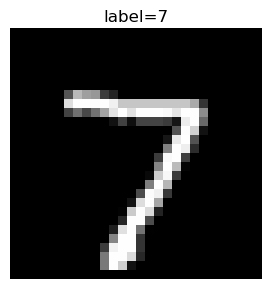

In [3]:
image_index = 0
xlab.utils.show_grayscale_image(mnist_images[image_index], title=f"label={mnist_labels[image_index]}")

## Loading White-Box Models

Next let's load the models that we will use to generate our transferable adversarial examples. We will be using a diverse set of models:

1. **A Resnet model**, similar to the MiniWideResnet model you used in previous sections.
   * Test set accuracy: 97.61%
3. **A CNN model**, which is a simple model that has three convolutional layers and three dense layers.
   * Test set accuracy: 96.74%
5. **A MLP model** which contains three standard fully connected layers.
   * Test set accuracy: 94.27%

Code for how we trained each of these models can be found [here](https://github.com/zroe1/xlab-ai-security/tree/main/models/MNIST_ensemble). To load the models on your computer, you can run the cells below.

In [4]:
from huggingface_hub import hf_hub_download
from xlab.models import ConvolutionalMNIST, ResNetMNIST, BasicBlockMNIST, FeedforwardMNIST

model_path = hf_hub_download(
    repo_id="uchicago-xlab-ai-security/mnist-ensemble",
    filename="mnist_wideresnet.pth"
)
white_box1 = torch.load(model_path, map_location=device, weights_only=False)


model_path = hf_hub_download(
    repo_id="uchicago-xlab-ai-security/mnist-ensemble",
    filename="mnist_simple_cnn.pth"
)
white_box2 = torch.load(model_path, map_location=device, weights_only=False)


model_path = hf_hub_download(
    repo_id="uchicago-xlab-ai-security/mnist-ensemble",
    filename="mnist_mlp.pth"
)
white_box3 = torch.load(model_path, map_location=device, weights_only=False)


## Loading Black-Box Models

Now we can load our black box model which we will attempt to attack in this notebook. You will interact with this model through our python package and you wont be able to see anything about the model architecture. You will be able to only call `model.predict` to get model predictions for a set of images and `model.predict_proba` to get model probabilities for a set of images.

In [5]:
import xlab
from xlab.models import BlackBox

# Load the black box model (downloads automatically)
model = xlab.utils.load_black_box_model('mnist-black-box')

# Make predictions (model details are hidden)
predictions = model.predict(mnist_images)
probabilities = model.predict_proba(mnist_images)

print(f"predictions={predictions}")
print(f"probabilities.shape={probabilities.shape}")

predictions=tensor([7, 2, 1, 0, 4, 1, 4, 9, 6, 9, 0, 2, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 0, 7, 2, 7, 1, 3, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 4, 3, 7, 4, 2, 4, 3, 0, 7, 0,
        2, 7, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6, 4, 3, 1, 4,
        1, 7, 6, 9])
probabilities.shape=torch.Size([100, 10])


## Task #1: Ensemble Loss

Given an array of $k$ alpha values and $k$ models you will give the weighted cross entropy loss by the following equation:

$$
\mathrm{argmin}_\delta \  \  D(\delta) + \sum_{i=1}^k \alpha_i \cdot \ell_i(x + \delta)
$$

In [6]:
def ensemble_loss(alphas, models, img, target):
    loss = torch.tensor(0.0).to(device)
    loss_fn = torch.nn.CrossEntropyLoss()

    for alpha, model in zip(alphas, models):
        out = model(img)
        model_loss = loss_fn(out, target)
        loss += alpha * model_loss
        # print(model_loss)

    return loss

In [7]:
img = mnist_images[0:1].to(device)
alphas = [1/3, 1/3, 1/3]
models = [white_box1, white_box2, white_box3]

example_loss = ensemble_loss(alphas, models, img, torch.tensor([0]).to(device))

## Task #2: Ensemble Attack

Now you should be in a good position to complete the ensemble attack. This is exactly the same as PGD, but instead of using a typical loss like Cross Entropy, you will be using the ensemble loss you implemented in `Task #1`. Note that in the original paper, the authors implement something more similar to Carlini-Wagner with a hyperparameter $\lambda$ which controls how much the distance metric is weighted in the final loss. For simplicity and compatibility with our tests you should use the update rule below:

$$
x'_i = x + \mathrm{clip}_\epsilon(\alpha \cdot \mathrm{sign}(\nabla \mathrm{ensemble\_loss}_{F,t}(x'_{i-1})))
$$

For the purpose of not making this too difficult, we have allowed a very high $\epsilon$ value. While one may exect $\epsilon=28/255$ to yeild some absurd results, in practice this is somewhat reasonable because of the high-contrast nature of the dataset. Also, because it is a gray-scale image, there are fewer pixel values to work with so the total distance of the purturbation (if you take the absolute value and sum) will be comparable to (probably less than) $\epsilon=12/255$ for a color image.

<b>Note:</b> You may use our solution to the clip function from the PGD notebook by calling `xlab.utils.clip`. You can also implement this functionality again within this notebook if you prefer.

In [97]:
def ensemble_attack_PGD(alphas, models, img, target, epsilon=24/255, alpha=2/255, num_iters=50):
    img_original = img.clone()
    adv_img = xlab.utils.add_noise(img)

    for _ in range(num_iters):
        adv_img.requires_grad=True
        loss = ensemble_loss(alphas, models, adv_img, target)
        loss.backward()
        # print(loss)

        grad = adv_img.grad.data
        adv_img.requires_grad_(False)
        adv_img -= alpha * torch.sign(grad)
        adv_img = xlab.utils.clip(adv_img, img_original, epsilon)

    return adv_img

As a first check, you should see that the targeted attack on the image below should succeed when the target class is 2. If this does not work, we reccomend going back and double checking your code before running the test in the next section of the notebook.

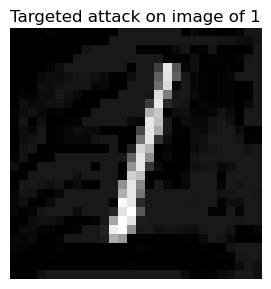

Black box predicts 2


In [107]:
img = mnist_images[2:3].to(device)
adv_img = ensemble_attack_PGD(alphas, models, img, torch.tensor([2]).to(device))
xlab.utils.show_grayscale_image(adv_img[0], "Targeted attack on image of 1")
predictions = model.predict(adv_img)
print(f"Black box predicts {predictions.item()}")

# Testing Your Attack

Transfering targeted adversarial examples is difficult. To make things easier for you we have identified a list of 5 images which we were able to generate transferable adversarial images for quite easily. For testing, you can run the cell below which will run your attack on these 5 images with the target class 3 (none of the images in `breakable_imgs` has a clean label of 3).

In [104]:
breakable_idxs = [5, 11, 14, 15, 17]
target_class = 3

breakable_imgs = [mnist_images[i:i+1].to(device) for i in breakable_idxs]
adv_imgs = []

for img in breakable_imgs:
    adv_img = ensemble_attack_PGD(alphas, models, img, torch.tensor([target_class]).to(device))
    adv_imgs.append(adv_img)
    
    predictions = model.predict(adv_img)
    if predictions.item() == target_class:
        print(f"Attack was successful! Predicted class = {target_class}")
    else:
        print(f"Attack was unsuccessful. Predicted class = {predictions.item()} and target class = {target_class}")

Attack was successful! Predicted class = 3
Attack was successful! Predicted class = 3
Attack was successful! Predicted class = 3
Attack was successful! Predicted class = 3
Attack was successful! Predicted class = 3


## Further Exploration

If you are interested, we encourage you to play around with the attack above to see if you can successfully transfer targeted attacks to other classes or to other images in the testing set. Although you should be able to do better than our solution (ours is the bare minimum) you should not expect to be able to complete this attack for every image for every class. In general, these kinds of targeted attacks are difficult to pull off and often require a more involved solution.

Ideas for how to improve the attack:

1. Tune the alpha values and see how different weights influence your chance of success (you should find this to be the case)
2. Try a more sophisticated optimization approach. Instead of using `alpha` to update the image, try using a PyTorch optimizer.
3. Go back to the [original paper](https://arxiv.org/pdf/1611.02770) and try to implement something closer to their "Optimization based approach"